In [115]:
import pandas as pd
import astromet
from scanninglaw import times
from scanninglaw.config import config
import matplotlib.pyplot as plt
import emcee
import corner
from multiprocessing import Pool

config['data_dir'] = '.'

In [3]:
bss_candidates = pd.DataFrame = pd.read_csv('./bss_candidates.csv')

In [6]:
wierd_candidates = bss_candidates[bss_candidates.ruwe>1.4]

In [14]:
wierd_candidates.ruwe

7     1.496976
17    1.410349
Name: ruwe, dtype: float64

In [64]:
wierd_candidates

,H,H_error,J,J_error,K,K_error,source_id,twomass_id,g,g_error,...,A_K,BP-RP,BP-RP_error,G_abs,G_abs_error,g-r,g-r_error,g_abs,g_abs_error,outlier
7,12.315,0.051,12.477,0.033,12.252,0.030,573939954395446016,00490340+8515251,13.6291,0.004411,...,0.112567,0.486820,0.000990,1.706961,0.063146,-0.067172,0.004411,0.974384,0.063299,-1
17,13.157,0.035,13.349,0.029,13.051,0.035,573942943692668416,00471341+8516398,14.7634,0.000315,...,0.112567,0.628606,0.001432,2.873883,0.076728,0.037928,0.002767,2.244449,0.076729,-1


In [47]:
wierd_candidates[['ra', 'dec', 'pmra', 'pmdec', 'parallax', 'G']]

,ra,dec,pmra,pmdec,parallax,G
7,12.264081,85.257001,-2.260835,-1.011430,0.538017,13.358162
17,11.805922,85.277745,-2.294059,-1.041704,0.572729,14.389319


In [93]:
REAL_DATA = wierd_candidates[['parallax', 'pmra', 'pmdec', 'parallax_error', 'pmra_error', 'pmdec_error', 'astrometric_excess_noise']].values[0]

In [94]:
REAL_DATA

array([ 0.53801712, -2.26083525, -1.01143032,  0.01564525,  0.01927799,
        0.01784258,  0.1290149 ])

In [48]:
RA = 12.264081
DEC = 85.257001
PMRA = -2.260835
PMDEC = -1.011430
PARALLAX = 0.538017
MAG = 13.358162

In [30]:
times.fetch(version='dr3_nominal')

  1.5 MiB of 543.4 MiB |  14.5 MiB/s |                  |   0% | ETA:   0:00:37

543.4 MiB of 543.4 MiB |  17.2 MiB/s |##################| 100% | ETA:  00:00:00

In [31]:
dr3_sl = times.Times(version='dr3_nominal')

Loading auxilliary data ...
t = 60.461 s
  auxilliary:  32.410 s
          sf:  10.883 s
interpolator:  17.167 s


In [32]:
def times_phis(ra, dec):
    c=scanninglaw.source.Source(ra,dec,unit='deg')

    sl=dr3_sl(c, return_times=True, return_angles=True)

    ts=np.squeeze(np.hstack(sl['times'])).astype('double')
    sort=np.argsort(ts)
    ts=2010+ts[sort]/365.25
    phis=np.squeeze(np.hstack(sl['angles']))[sort].astype('double')
    return ts, phis

In [35]:
times_phis(RA, DEC)

(array([2014.65587507, 2014.65607769, 2014.86554964, 2014.86575225,
        2014.91483269, 2015.17400503, 2015.25562504, 2015.25610733,
        2015.33959062, 2015.53119553, 2015.53139815, 2015.63177094,
        2015.72548553, 2015.72568815, 2015.79254783, 2015.89851373,
        2015.94574447, 2016.05169848, 2016.0519011 , 2016.11007158,
        2016.11055387, 2016.20561602, 2016.20581864, 2016.29455797,
        2016.37531369, 2016.37551631, 2016.49026062, 2016.49046324,
        2016.57170428, 2016.5719069 , 2016.76187513, 2016.76207775,
        2016.8229853 , 2016.82346759, 2016.93010877, 2016.93031139,
        2016.97733982, 2017.0819327 , 2017.08213532, 2017.14524804,
        2017.33385305, 2017.33405567]),
 array([ 167.65607854,  170.90083456,   12.16475688,   15.69997236,
          72.16098535, -109.4761215 ,  -44.27462844,  -49.8795099 ,
        -163.6922817 ,  129.59864198,  127.68656128,  178.04716353,
          55.80691176,   57.82059528,  124.25049693,    4.27243148,
        

In [132]:
params=astromet.params()

params.ra=RA
params.dec=DEC
params.drac=0
params.ddec=0
params.pmrac=PMRA
params.pmdec=PMDEC
params.parallax=PARALLAX

ts, phis = times_phis(RA, DEC)
al_error=astromet.sigma_ast(MAG)
errs=np.repeat(al_error*np.random.randn(phis.size), 9)

def mock_obs_vec(period, a, e, q, l):
    global params
    params.period=period
    params.a=a
    params.e=e
    params.q=q
    params.l=l

    params.vphi=4.5
    params.vtheta=1.5
    params.vomega=5.6

    params.tperi=2016
    
    racs, decs = astromet.track(ts, params)

    t_obs, x_obs, phi_obs, rac_obs, dec_obs = astromet.mock_obs(ts, phis, racs, decs, err=errs)
    results = astromet.fit(t_obs, x_obs, phi_obs, al_error, RA, DEC)
    
    return np.array([results['parallax'], results['pmrac'], results['pmdec'],
                     results['parallax_error'], results['pmrac_error'], results['pmdec_error'],
                     results['excess_noise']])

In [133]:
mock_obs_vec(2, 1, 0.5, .8, .1)

array([ 0.52552006, -2.31080777, -1.01741942,  0.01130771,  0.0147267 ,
        0.0135514 ,  0.        ])

In [134]:
def log_prior(theta):
    if np.any(theta<0):
        return -np.inf
    return 0.0

In [135]:
def log_likelihood(theta):
    y = mock_obs_vec(*theta)
    return -0.5 * np.sum(((y - REAL_DATA)/REAL_DATA) ** 2)

In [136]:
def log_probability(theta):
    prob = log_prior(theta)+log_likelihood(theta)
    if np.isnan(prob):
        return -np.inf
    else:
        return prob

In [143]:
nwalkers, ndim = 25, 5

sigmas = np.random.normal(size=(nwalkers, ndim))

with Pool() as pool:
    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, pool=pool,
    )
    sampler.run_mcmc(np.array([2., 1., 0.5, .5, .5])+sigmas, 1000, progress=True);

/home/mjablons/.local/lib/python3.9/site-packages/astromet/tracks.py:382: RuntimeWarning: invalid value encountered in sqrt
  phis = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(etas/2)) % (2*np.pi)
/home/mjablons/.local/lib/python3.9/site-packages/astromet/tracks.py:382: RuntimeWarning: invalid value encountered in sqrt
  phis = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(etas/2)) % (2*np.pi)
/home/mjablons/.local/lib/python3.9/site-packages/astromet/tracks.py:382: RuntimeWarning: invalid value encountered in sqrt
  phis = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(etas/2)) % (2*np.pi)
  0%|                                                  | 0/1000 [00:00<?, ?it/s]/home/mjablons/.local/lib/python3.9/site-packages/astromet/tracks.py:382: RuntimeWarning: invalid value encountered in sqrt
  phis = 2*np.arctan(np.sqrt((1+e)/(1-e))*np.tan(etas/2)) % (2*np.pi)
/home/mjablons/.local/lib/python3.9/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpd

In [148]:
np.savetxt('mcmc_samples.dat', sampler.get_chain().reshape((-1, 5)))

In [149]:
sampler.get_chain().shape

(1000, 25, 5)

In [156]:
chain = sampler.get_chain()[500:, :, :].reshape((-1, 5))

In [157]:
chain.shape

(12500, 5)

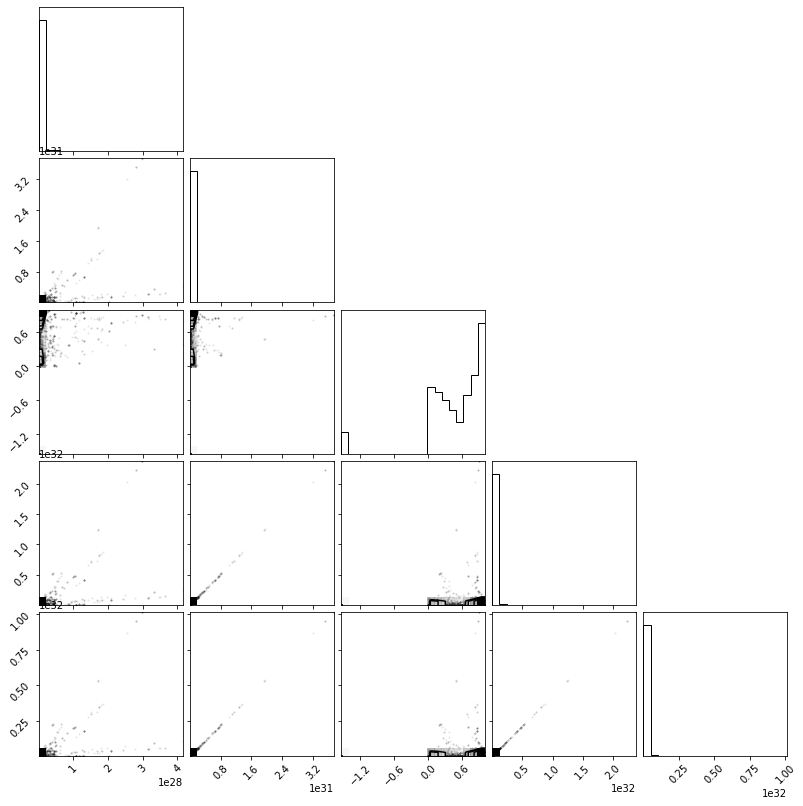

In [158]:
corner.corner(chain);

In [161]:
np.quantile(chain, [0.16, 0.5, 0.84], axis=0)

array([[7.38362088e+15, 6.07118485e+16, 1.06605069e-01, 6.31529345e+16,
        3.24800953e+16],
       [2.18333801e+22, 1.90244491e+23, 5.94274055e-01, 9.31515106e+22,
        6.77184252e+22],
       [3.22173029e+25, 3.49785936e+27, 9.21647967e-01, 1.43320692e+28,
        6.20004466e+27]])